In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import math
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from livelossplot import PlotLossesKeras
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mpl_toolkits.axes_grid1 import ImageGrid
import random 

from keras.layers.noise import GaussianNoise
import keras.backend as K
from keras.losses import binary_crossentropy
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Conv2D, MaxPooling2D,concatenate, UpSampling2D, merge, add

C:\Users\Wallace\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_DIR = "F:\\dataset"
DATASET_PEOPLE =  DATASET_DIR+"\\person"
TRAIN_SET_PEOPLE_DIR = DATASET_PEOPLE+"\\train_set"
TRAIN_SET_IMGS_PEOPLE_DIR = DATASET_PEOPLE+"\\train_set\\images"
TRAIN_SET_ANN_PEOPLE_DIR = DATASET_PEOPLE+"\\train_set\\annotation"

VAL_SET_PEOPLE_DIR = DATASET_PEOPLE+"\\val_set"
VAL_SET_IMGS_PEOPLE_DIR = DATASET_PEOPLE+"\\val_set\\images"
VAL_SET_ANN_PEOPLE_DIR = DATASET_PEOPLE+"\\val_set\\annotation"

TEST_SET_PEOPLE_DIR = DATASET_PEOPLE+"\\test_set"
TEST_SET_IMGS_PEOPLE_DIR = DATASET_PEOPLE+"\\test_set\\images"
TEST_SET_ANN_PEOPLE_DIR = DATASET_PEOPLE+"\\test_set\\annotation"

GENERAL_TEST_IMG = DATASET_PEOPLE+"\\general_teste\\images"
GENERAL_TEST_ANN = DATASET_PEOPLE+"\\general_teste\\annotation"

In [3]:
### Loos function

def dice_coef(y_true, y_pred):
    ''' Metric used for CNN training'''
    smooth = 1.0 #CNN dice coefficient smooth
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    ''' Loss function'''
    return -dice_coef(y_true, y_pred)

In [4]:
def read_image(PATH, size_img, gray=False):

    img = image.load_img(PATH, target_size=(size_img, size_img), grayscale=gray)     
    x = image.img_to_array(img)
    x = x * 1./255
    
    return x

In [5]:
def train_generator(DIR_IMG, DIR_MASK, img_size, batch_size = 32, shuffle = True):
    
    batch_images = np.empty((batch_size, img_size, img_size, 3))
    batch_masks = np.empty((batch_size, img_size, img_size))
    
    files = os.listdir(DIR_IMG)
    files = np.asarray(files)

    while True:
        for i in range(batch_size):
            if shuffle == True:
                name_id = random.randint(0,files.shape[0]-1)
            else:
                name_id = i
            
            path_img = DIR_IMG+"\\"+files[name_id]
            img = read_image(path_img, img_size)
            
            path_mask = DIR_MASK+"\\"+files[name_id]
            mask = read_image(path_mask, img_size, True)
            mask = mask.reshape(img_size,img_size)
            
            batch_images[i] = img
            batch_masks[i] = mask
            
        yield batch_images, batch_masks
            

In [6]:
img_sz = 256
batch_size = 5
train_gen = train_generator(TRAIN_SET_IMGS_PEOPLE_DIR, TRAIN_SET_ANN_PEOPLE_DIR, img_sz, batch_size)
val_gen = train_generator(VAL_SET_IMGS_PEOPLE_DIR, VAL_SET_ANN_PEOPLE_DIR, img_sz, batch_size)
test_gen = train_generator(TEST_SET_IMGS_PEOPLE_DIR, TEST_SET_ANN_PEOPLE_DIR, img_sz, batch_size)

batch_img, batch_mask = next(train_gen)

(5, 256, 256, 3)


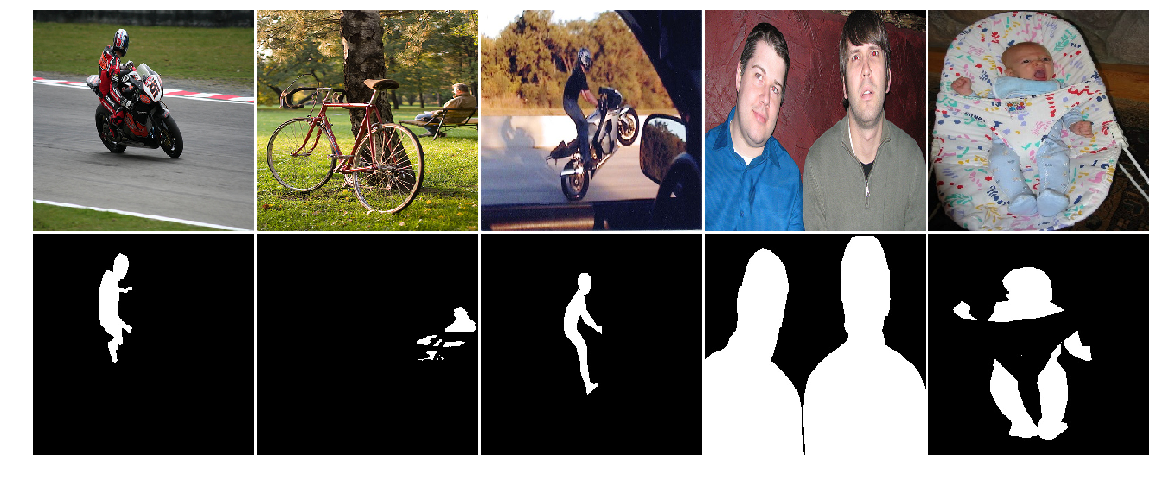

In [7]:
fig = plt.figure(figsize=(20,20))
print(batch_img.shape)
#from https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.04,  # pad between axes in inch.
                 )
font = {'family': 'serif',
        'size': 14,
        }
for i in range(5):
    ax = grid[i]
    ax.imshow(batch_img[i])
    ax.axis('off')
for i in range(5):
    ax = grid[i+5]
    ax.imshow(batch_mask[i],cmap="gray")
    ax.axis('off')
plt.show()

In [8]:
def get_unet_mod(patch_size = (None,None),learning_rate = 1e-5,\
                 learning_decay = 1e-6,gn_std = 0.025, drop_out = 0.25,nchannels = 3,kshape = (3,3)):
    ''' Get U-Net model with gaussian noise and dropout'''
    
    gaussian_noise_std = gn_std
    dropout = drop_out
    
    input_img = Input((patch_size[0], patch_size[1],nchannels))
    input_with_noise = GaussianNoise(gaussian_noise_std)(input_img)    

    conv1 = Conv2D(32, kshape, activation='relu', padding='same')(input_with_noise)
    conv1 = Conv2D(32, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    conv5 = Conv2D(512, kshape, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, kshape, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4],axis=-1)
    up6 = Dropout(dropout)(up6)
    conv6 = Conv2D(256, kshape, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, kshape, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3],axis=-1)
    up7 = Dropout(dropout)(up7)
    conv7 = Conv2D(128, kshape, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, kshape, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2],axis=-1)
    up8 = Dropout(dropout)(up8)
    conv8 = Conv2D(64, kshape, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, kshape, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    up9 = Dropout(dropout)(up9)
    conv9 = Conv2D(32, kshape, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, kshape, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=input_img, outputs=conv10)
    opt = optimizers.Adam(lr= learning_rate, decay = learning_decay)
    model.compile(optimizer= opt,loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [9]:
model = get_unet_mod(patch_size = (img_sz,img_sz),\
                     learning_rate = 1e-4,\
                     learning_decay = 5e-9)

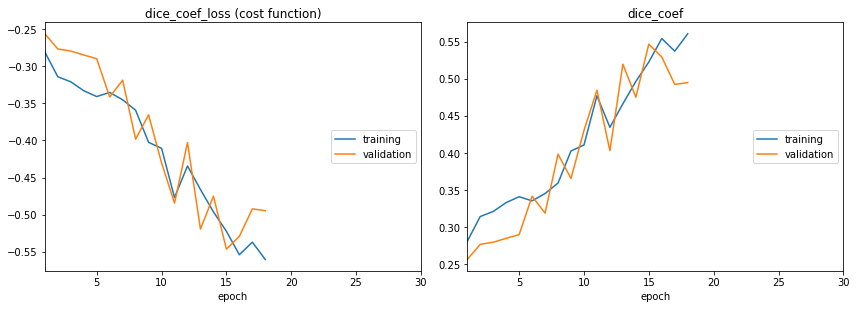

Epoch 00018: early stopping


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 
callbackscallbac  = [early_stopping]


history = model.fit_generator(
train_gen,
callbacks= callbackscallbac,
steps_per_epoch=376//batch_size,#size of the dataset divided by the size of the batch
epochs=30,
validation_data=val_gen,
validation_steps=93//batch_size)

### Testing

In [22]:
test_gen = train_generator(GENERAL_TEST_IMG, GENERAL_TEST_ANN, img_sz, 5, False)
batch_img, batch_mask = next(test_gen)

(5, 256, 256, 3)


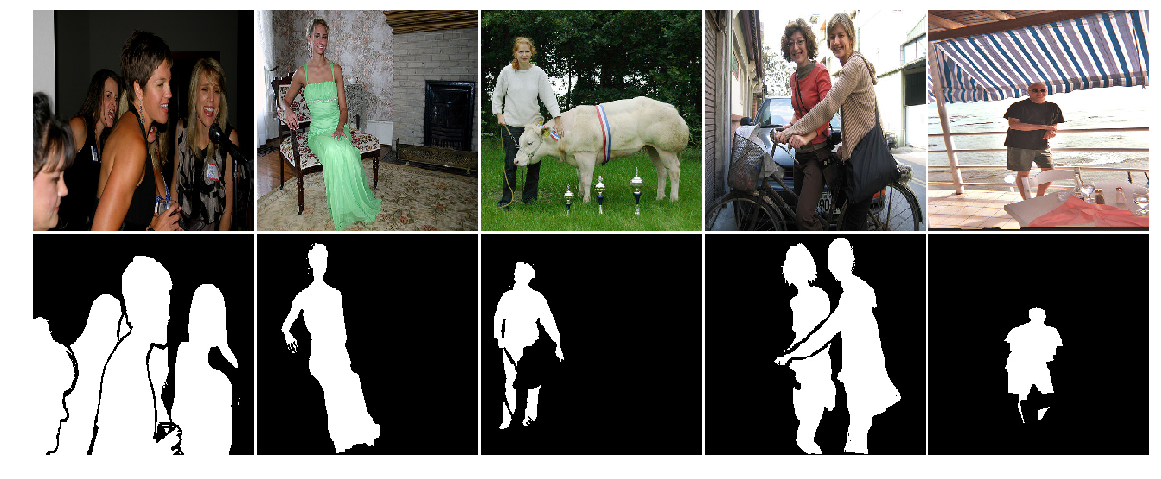

In [17]:
fig = plt.figure(figsize=(20,20))
print(batch_img.shape)
#from https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.04,  # pad between axes in inch.
                 )
font = {'family': 'serif',
        'size': 14,
        }
for i in range(5):
    ax = grid[i]
    ax.imshow(batch_img[i])
    ax.axis('off')
    
for i in range(5):
    ax = grid[i+5]
    mask_img = np.zeros(batch_img[i].shape, dtype="uint8")

    mask_img[batch_mask[i]>0] = (1, 1, 0)
    alfa = 0.5
    new_img = (batch_img[i]+alfa*mask_img)
    new_img = new_img/np.max(new_img)
    ax.imshow(batch_mask[i], cmap="gray")
    ax.axis('off')
plt.show()

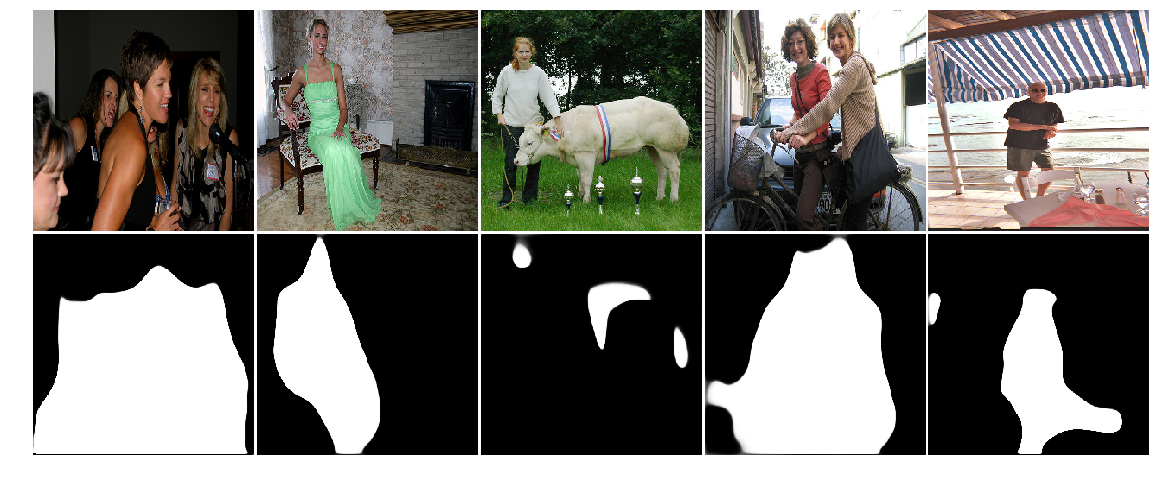

In [25]:
fig = plt.figure(figsize=(20,20))
#from https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.04,  # pad between axes in inch.
                 )
font = {'family': 'serif',
        'size': 14,
        }
for i in range(5):
    ax = grid[i]
    ax.imshow(batch_img[i])
    ax.axis('off')
    
for i in range(5):
    ax = grid[i+5]
    data = np.copy(batch_img[i])
    
    x = np.expand_dims(data, axis=0)
                
    mask_pred = model.predict(x)
    mask = mask_pred[0]
    mask = mask.reshape(mask.shape[0],mask.shape[1])

    mask_img = np.zeros(batch_img[i].shape, dtype="uint8")

    mask_img[mask>0.4] = (1, 1, 0)
    alfa = 0.4
    new_img = (batch_img[i]+alfa*mask_img)
    new_img = new_img/np.max(new_img)
    
    #ax.imshow(mask>0.4)
    ax.imshow(mask, cmap="gray")
    ax.axis('off')
plt.show()

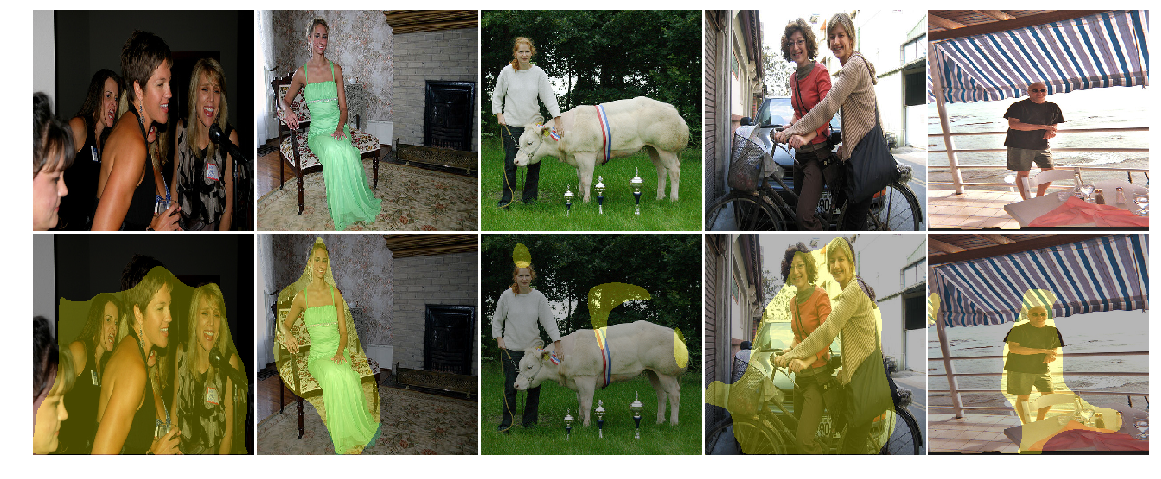

In [26]:
fig = plt.figure(figsize=(20,20))
#from https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.04,  # pad between axes in inch.
                 )
font = {'family': 'serif',
        'size': 14,
        }
for i in range(5):
    ax = grid[i]
    ax.imshow(batch_img[i])
    ax.axis('off')
    
for i in range(5):
    ax = grid[i+5]
    data = np.copy(batch_img[i])
    
    x = np.expand_dims(data, axis=0)
                
    mask_pred = model.predict(x)
    mask = mask_pred[0]
    mask = mask.reshape(mask.shape[0],mask.shape[1])

    mask_img = np.zeros(batch_img[i].shape, dtype="uint8")

    mask_img[mask>0.4] = (1, 1, 0)
    alfa = 0.4
    new_img = (batch_img[i]+alfa*mask_img)
    new_img = new_img/np.max(new_img)
    
    #ax.imshow(mask>0.4)
    ax.imshow(new_img, cmap="gray")
    ax.axis('off')
plt.show()